In [631]:
%matplotlib inline
from scipy.ndimage.filters import gaussian_filter
from ipywidgets import interact, interactive, fixed, HBox, VBox
import ipywidgets as ipw
import numpy as np
from brian2 import *
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.ndimage.interpolation import zoom
from IPython.display import display

In [632]:
def nan_gaussian_filter(x, sigma, num_passes):
    z = full_like(x, nan)
    for cursigma in linspace(sigma, 0, num_passes + 1)[:-1]:
        y = gaussian_filter(x, cursigma, mode='nearest')
        z[isnan(z)] = y[isnan(z)]
    return z

In [633]:
def create_linspaces(var_i, N_var, min_var,  max_var):
    return{
        0: linspace(min_var, max_var, N_var)*ms,
        1: linspace(min_var, max_var, N_var)*ms,
        2: linspace(min_var, max_var, N_var),
        3: linspace(min_var, max_var, N_var),
        4: linspace(min_var, max_var, N_var),
        5: linspace(min_var, max_var, N_var),
        6: linspace(min_var, max_var, N_var),
        7: linspace(min_var, max_var, N_var),        
    }[var_i] 

In [634]:
def set_quality(quality):
    if quality == 0:
        N = 15
        duration = 50 * ms
        skip_time = 25 * ms
        blur_width = 0.05
        N_varX = 20  
        N_varY = 20  
    elif quality == 1:
        N = 25
        duration = 100 * ms
        skip_time = 50 * ms
        blur_width = 0.1
        N_varX = 25 
        N_varY = 25  
    elif quality == 2:
        N = 30
        duration = 250 * ms
        skip_time = 50 * ms
        blur_width = 0.1
        N_varX = 30
        N_varY = 30 
    elif quality == 3:
        N = 40
        duration = 800 * ms
        skip_time = 100 * ms
        blur_width = 0.05
        N_varX = 30  
        N_varY = 30  
    return N, duration, skip_time, blur_width, N_varX, N_varY

In [635]:
def set_input_param(tau, t_ref, varX_i, varY_i, N_varX, N_varY, N, 
                    paramlist, min_varX, max_varX, min_varY, max_varY):
    # Units
    tau = tau * ms
    t_ref = t_ref * ms
    
    # Create Linspaces    
    varX = create_linspaces(varX_i, N_varX, min_varX, max_varX)
    varY = create_linspaces(varY_i, N_varY, min_varY, max_varY)
    sizeX = varX.size
    sizeY = varY.size    
    varX = np.tile(varX, sizeY * N)      
    varY = np.repeat(varY, sizeX * N)  
    
    #Update list and vars
    for index, item in enumerate(paramlist):
        if varX_i==index:
            paramlist[index]=varX
        if varY_i==index:
            paramlist[index]=varY
            
    tau = paramlist[0]
    t_ref = paramlist[1]
    N_exc = paramlist[2]
    fr_exc = paramlist[3]
    mu_exc = paramlist[4]
    fr_inh = paramlist[5]
    alpha = paramlist[6]
    beta = paramlist[7] 
 
    w_exc = ((mu_exc) / (tau * N_exc * fr_exc))/Hz
    N_inh = N_exc * alpha
    w_inh = w_exc * beta 
    return tau, t_ref, N_exc, fr_exc, fr_inh, w_exc, N_inh, w_inh

In [636]:
def sim(tau, t_ref, N_exc, fr_exc, fr_inh, w_exc, N_inh, w_inh, N, N_varX, N_varY, duration):
    # Equation for each Cell
    eqs = '''
        dv/dt = (mu-v)/tau+sigma*xi*tau**-0.5 : 1 (unless refractory)
        mu : 1
        sigma: 1
        tau : second
        t_ref : second
        '''

    # Simulation for  N*N_varX*N_varY cells for each possible combination of sigma and mu
    G = NeuronGroup(N * N_varX * N_varY, eqs, threshold='v>1', reset='v=0', refractory='t_ref', method='euler')
    M = SpikeMonitor(G)

    G.mu = np.asarray(tau * ((w_exc * N_exc * fr_exc) - (w_inh * N_inh * fr_inh)))
    G.sigma = np.sqrt(np.asarray(tau * (w_exc ** 2 * N_exc * fr_exc + w_inh ** 2 * N_inh * fr_inh)))
    G.tau = tau
    G.t_ref = t_ref

    run(duration)
    return M

In [637]:
def get_CV_FR(M, N, N_varX, N_varY, duration, skip_time):
    # Results Analysis
    SpikeTrains = M.spike_trains()
    CV_v = np.zeros((N * N_varX * N_varY))
    FR_v = np.zeros((N * N_varX * N_varY))

    #   Obtain CV value for each simulated Cell and store them in CV_v vector
    for index in range(N * N_varX * N_varY):
        T = SpikeTrains[index]
        T = T[T > skip_time]
        SpikeTrains[index] = np.diff(np.sort(T))
        CV_v[index] = divide(np.std(SpikeTrains[index]), np.mean(SpikeTrains[index]))
        FR_v[index] = np.size(T) / (duration - skip_time)

        # Store the CV-averaged value in a matrix CV[i, j]
        # where i is the index of G.mu and j the index ofG.sigma
    CV = np.zeros((N_varX, N_varY))
    FR = np.zeros((N_varX, N_varY))
    tmp_CV = 0
    tmp_FR = 0

    for i in range(N_varY):
        for j in range(N_varX):
            for k in range(N):
                tmp_CV += CV_v[i * N_varX * N + j + k * N_varX]
                tmp_FR += FR_v[i * N_varX * N + j + k * N_varX]
            CV[i, j] = tmp_CV / N
            FR[i, j] = tmp_FR / N
            tmp_CV = 0
            tmp_FR = 0
            
    return CV, FR

In [638]:
def gen_graph(tau, t_ref, N_exc, fr_exc, mu_exc, fr_inh, alpha, beta, 
              varX_i, varY_i, quality, min_varX, max_varX, min_varY, max_varY):
    
    start_scope()    
    
    paramlist = [tau*ms, t_ref*ms, N_exc, fr_exc, mu_exc, fr_inh, alpha, beta]
    
    N, duration, skip_time, blur_width, N_varX, N_varY = set_quality(quality) 
    
    tau, t_ref, N_exc, fr_exc, fr_inh, w_exc, N_inh, w_inh = set_input_param(tau, t_ref, 
                                                                             varX_i, varY_i, 
                                                                             N_varX, N_varY, 
                                                                             N, paramlist, 
                                                                             min_varX, max_varX, 
                                                                             min_varY, max_varY)
    
    M = sim( tau, t_ref, N_exc, fr_exc, fr_inh, w_exc, N_inh, w_inh, N, N_varX, N_varY, duration)
    
    CV, FR = get_CV_FR(M, N, N_varX, N_varY, duration, skip_time)
    
    plot_CV(CV, FR, min_varX, max_varX, min_varY, max_varY, blur_width, N, varX_i, varY_i)
    return

In [639]:
def plot_CV(CV, FR, min_varX, max_varX, min_varY, max_varY, blur_width, N, varX_i, varY_i):
    
    paramlist = ['tau', 'Refractory Time', 'Number of Exc Synapses', 'Exc firing rate', 
                 'mu Excitatory', 'Inh firing rate', 'Alpha', 'Beta']
    ax = plt.gca()
    ax.set_axis_bgcolor('grey')
    CV = nan_gaussian_filter(CV, blur_width * CV.shape[0], 10)
    FR = nan_gaussian_filter(FR, blur_width * FR.shape[0], 10)
    CV = zoom(CV, 100./N, order=1)
    FR = zoom(FR, 100./N, order=1)
    im = plt.imshow(CV, interpolation='nearest', origin='lower left', aspect='auto',
                    cmap=cm.YlGnBu_r, extent=(min_varX, max_varX, min_varY, max_varY), norm=colors.Normalize(0, 1))
    
    if varX_i == 4 and (varY_i == 0 or varY_i == 2 or varY_i == 3):
        xlabel(paramlist[varX_i] + '/' + paramlist[varY_i])
    else:
        xlabel(paramlist[varX_i])
    if varY_i == 4 and (varX_i == 0 or varX_i == 2 or varX_i == 3):
        ylabel(paramlist[varY_i] + '/' + paramlist[varX_i])
    else:
        ylabel(paramlist[varY_i])

    levels_CV = np.array([0.35, 0.8])
    CS = plt.contour(CV, levels_CV,
                     origin='lower',
                     linewidths=2,
                     extent=(min_varX, max_varX, min_varY, max_varY))
    plt.clabel(CS, levels_CV[0:2],
               inline=1,
               fmt='%1.2f',
               fontsize=14)

    levels_FR = np.array([50, 400])
    CS = plt.contour(FR, levels_FR,
                     origin='lower',
                     linewidths=2,
                     extent=(min_varX, max_varX, min_varY, max_varY),
                     linestyles='dashed')
    plt.clabel(CS, levels_FR[0:2],
               inline=1,
               fmt='%1.1f',
               fontsize=14)

    # make a colorbar for the image
    cb = plt.colorbar(im, orientation='horizontal', shrink=0.8)
    cb.set_label('CV', rotation=0, labelpad=20)
    return

In [640]:
class VCN_psapce:
    def __init__(self):       
        
        #Dropdown to select which graph we want
        self.varX = ipw.Dropdown(options=OrderedDict([('tau', 0), ('Refractory Time', 1), ('Number of Exc Synapses', 2),
                                                ('Exc firing rate', 3), ('mu Excitatory', 4),
                                                ('Inh firing rate', 5), ('Alpha', 6), ('Beta', 7)]), value=4,
                                                description="X var")
        self.varY = ipw.Dropdown(options=OrderedDict([('tau', 0), ('t_ref', 1), ('Number of Exc Synapses', 2),
                                                ('Exc firing rate', 3), ('mu Excitatory', 4),
                                                ('Inh firing rate', 5), ('Alpha', 6), ('Beta', 7)]), value=2,
                                                description="Y Var")
        self.go = ipw.Button(description='Go') # Run graph
        self.ErrorText = ipw.Text(description='Error:', value='None') #Indicates if varaibls are incompatible
        self.paramlist = [r"$\tau$", 'Refractory Time', 'Number of Exc Synapses', 'Exc firing rate', 'mu Excitatory', 
                          'Inh firing rate', 'Alpha', 'Beta']
        
        self.initial_axis = initial_axis = {0: (0, 20), 
                                            1: (0, 5), 
                                            2: (0, 80), 
                                            3: (0, 400), 
                                            4: (0, 5), 
                                            5: (0, 400), 
                                            6: (0, 2), 
                                            7: (0, 8)} 
        
        #Create GUI and Graph
        self.openInit()
        self.go.on_click(self.start)
        
    def __del__(self):
        self.close()
        
    def closeInit(self):
        self.varX.close()         
        self.varY.close()            
        self.go.close()
        del self.go
        self.ErrorText.close()
        del self.ErrorText

    def openInit(self):
        self.go.width = '40%'
        self.go.right = '40%'
        display(self.varX)
        display(self.varY)
        display(self.go)   
        
    def paramSliders(self):
        tau=ipw.FloatSlider(value=5, min=0.1, max=20, step=0.1, 
                            description=r"$\tau$ (ms)", 
                            visible=not(self.varX.value == 0 or self.varY.value == 0))
        t_ref=ipw.FloatSlider(value=0.1, min=0, max=5, step=0.1, 
                              description=r"Refractory (ms)", 
                              visible=not(self.varX.value == 1 or self.varY.value == 1))
        N_exc=ipw.FloatSlider(value=50, min=1, max=80, step=5, 
                              description=r"Number of Exc Synapses", 
                              visible=not(self.varX.value == 2 or self.varY.value == 2))
        fr_exc=ipw.FloatSlider(value=50, min=50, max=400, step=50, 
                               description=r"Excitatory Firing Rate (sp/s)", 
                               visible=not(self.varX.value == 3 or self.varY.value == 3)) 
        mu_exc=ipw.FloatSlider(value=5, min=0, max=8, step=0.5, 
                               description=r"mu Excitatory", 
                               visible=not(self.varX.value == 4 or self.varY.value == 4)) 
        fr_inh=ipw.FloatSlider(value=50, min=0, max=400, step=50, 
                                description=r"Inhibitory Firing Rate (sp/s)", 
                                visible=not(self.varX.value == 5 or self.varY.value == 5)) 
        alpha=ipw.FloatSlider(value=0.2, min=0, max=2, step=0.1, 
                               description=r"Alpha (Number of Inhibitory over Excitatory synapses)", 
                               visible=not(self.varX.value == 6 or self.varY.value == 6))
        beta=ipw.FloatSlider(value=2, min=0, max=8, step=0.5, 
                              description=r"Beta (Weight of Inhibitory over Excitatory synapses)", 
                              visible=not(self.varX.value == 7 or self.varY.value == 7))                    
        quality=ipw.Dropdown(options=OrderedDict([('Very fast', 0),
                                               ('Fast', 1),
                                               ('Medium', 2),
                                               ('High / slow', 3)]),
                          value=1, description="Quality")
        min_varX = ipw.FloatText(value=self.initial_axis[self.varX.value][0], description='X-Axis from: ')
        max_varX = ipw.FloatText(value=self.initial_axis[self.varX.value][1], description='X-Axis to: ')
        min_varY = ipw.FloatText(value=self.initial_axis[self.varY.value][0], description='Y-Axis from: ')
        max_varY = ipw.FloatText(value=self.initial_axis[self.varY.value][1], description='Y-Axis to: ')
        
        return [tau, t_ref, N_exc, fr_exc, mu_exc, fr_inh, alpha, beta, quality, min_varX, max_varX, min_varY, max_varY]
        
    def start(self, b):
        if self.varX.value == self.varY.value: 
            self.ErrorText.value = 'Variables cannot be the same'
            display(self.ErrorText)
            
        else:
            
            textX = ipw.Text(description='X var:', value=str(self.paramlist[self.varX.value]), disabled=True)
            display(textX)
            textY = ipw.Text(description='Y var:', value=str(self.paramlist[self.varY.value]), disabled=True)
            display(textY)            
            self.closeInit()
            parameters = self.paramSliders()            
           
            interact(gen_graph, 
                     tau=parameters[0],
                     t_ref=parameters[1], 
                     N_exc=parameters[2],
                     fr_exc=parameters[3], 
                     mu_exc=parameters[4],
                     fr_inh=parameters[5], 
                     alpha=parameters[6],
                     beta=parameters[7], 
                     quality=parameters[8],  
                     min_varX=parameters[9], 
                     max_varX=parameters[10], 
                     min_varY=parameters[11], 
                     max_varY=parameters[12], 
                     varX_i=fixed(self.varX.value), 
                     varY_i=fixed(self.varY.value),
                    __manual=True);            

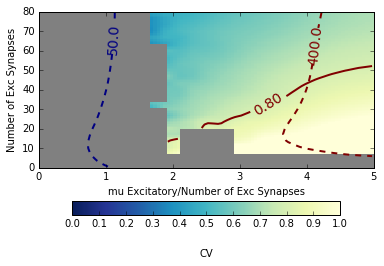

In [641]:
warnings.filterwarnings("ignore")
BrianLogger.log_level_error()
g = VCN_psapce()